In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from ipywidgets import interact
import numpy
from scipy import stats

flood_data = pd.read_csv('Ahsan_flood_data_13.csv')


Sukkur_Kotri: x=35.8,start=40,stop=82   -> 40,82,300,495,10

Guddu_Sukkur: x=57.7,start=47,stop=55   -> 43,55,0,1001,10

In [2]:
which_river = input("Which river? ")

if which_river == "Guddu_Sukkur":
    start_river, end_river = 'Guddu D/S (cfs)','Sukkur U/S (cfs)'
elif which_river == "Sukkur_Kotri":
    start_river, end_river = 'Sukkur D/S (cfs)', 'Kotri U/S (cfs)'
else:
    pass

inflow = flood_data[start_river] /43560 # 43560 cubic ft = 1 ac-ft
outflow = flood_data[end_river] /43560

dS = (inflow - outflow)*24*3600

#print(inflow[:10],outflow[:10])

Which river? Sukkur_Kotri


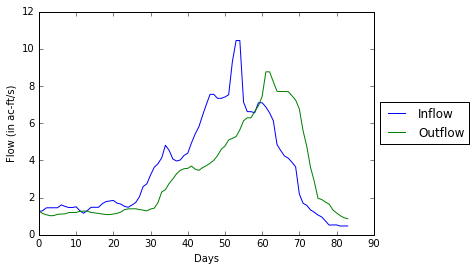

In [3]:
def plot_in_out_flow(_in = True, _out = True):
    if _in:
        plt.plot(inflow, label = 'Inflow')
    if _out:
        plt.plot(outflow, label = 'Outflow')
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('Flow (in ac-ft/s)') # Acre-foot per second
    plt.xlabel('Days')
    
plot_in_out_flow()

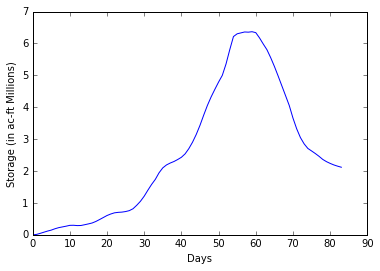

In [7]:
def get_storage(dS = dS):
    storage_river = pd.DataFrame.cumsum(dS)
    return storage_river

def plot_storage(storage_river):
    plt.plot(storage_river/1000000)
    plt.ylabel('Storage (in ac-ft Millions)')
    plt.xlabel('Days')
    if which_river == "Sukkur_Kotri":
        plt.axis((0,90,0,7))
    plt.show()

plot_storage(get_storage(dS))

In [8]:
def make_weighted_discharge(x):
    x = x/100
    weighted_discharge = (x*inflow) + (1-x)*outflow
    return weighted_discharge

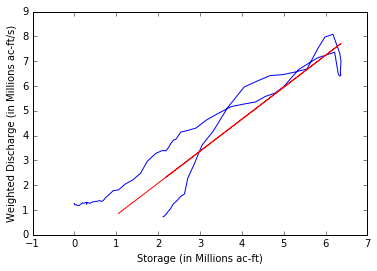

In [9]:
def find_r(x=57.2,stop=55,start=47,draw_start=29):
    storage_river = get_storage(dS)
    weighted_discharge = make_weighted_discharge(x)
    
    plt.plot(storage_river/1000000,weighted_discharge)
    plt.xlabel('Storage (in Millions ac-ft)')
    plt.ylabel('Weighted Discharge (in Millions ac-ft/s)')
    plt.plot(storage_river[draw_start:stop]/1000000, numpy.poly1d(numpy.polyfit(storage_river[start:stop]/1000000,
            weighted_discharge[start:stop], 1))(storage_river[draw_start:stop]/1000000), color='red')
    plt.show()
    
interact(find_r, x = (0.0,100.0), stop=(1,100),start=(0,100), draw_start=(0,100))

In [33]:
#a = numpy.poly1d(numpy.polyfit(storage_guddu_sukkur, make_weighted_discharge(58), 1))(storage_guddu_sukkur)
#len(a)
#type(a)
#print(a[83],new[83],ano_list[83])

In [10]:
def r_sq_form(start=47,end=55,s_times=0,e_times=100,div=1):
    all_r_sq = []
    storage_river = get_storage(dS)
    for i in range(s_times,e_times):
        weighted_discharge = make_weighted_discharge(i/div)
        slope, intercept, r_value, p_value, std_err = stats.linregress(storage_river[start:end], weighted_discharge[start:end])
        all_r_sq.append(r_value**2)
    
    return all_r_sq

In [11]:
def find_max_r_sq(start=47):
    all_r_sq = r_sq_form(start)
    return max(all_r_sq)
    #print("Max:", max_r_sq,"\nIndex:",all_r_sq.index(max_r_sq))

#plt.plot(all_r_sq, label='All r-sq')
#plt.ylabel('Correlation coefficient')
#plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

def find_start(a,b):
    _cur,store = 0,0
    for i in range(a,b):
        new = max(r_sq_form(i)) if which_river == "Guddu_Sukkur" else max(r_sq_form(i,67,300,495,10))
        #new = max(r_sq_form(i,67,300,495,10)) # For sukkur_Kotri
        if new > _cur:
            _cur,store = new,i

    return "Maximum Correlation is {0} when start = {1}".format(_cur,store)

a = find_start(35,48)
b = find_start(40,48)
print(a+"\n"+b)

Maximum Correlation is 0.9116379372550218 when start = 35
Maximum Correlation is 0.8562127127349225 when start = 40


In [12]:
(s,e) = (0,1001) if which_river == "Guddu_Sukkur" else (300,495)
#s,e = 300,495
all_r_sq = r_sq_form(43,55,s,e,10) if which_river == "Guddu_Sukkur" else r_sq_form(40,82,s,e,10)# For guddu_sukkur
#all_r_sq = r_sq_form(40,82,s,e,10)
max_r_sq = max(all_r_sq)
print("Max:", max_r_sq,"\nIndex:",(all_r_sq.index(max_r_sq)+s))

Max: 0.812726159914 
Index: 358


In [13]:
def find_k(start=43,end=55,x=57.7):
    weighted_discharge = make_weighted_discharge(x)
    storage_river = get_storage()
    slope, intercept, r_value, p_value, std_err = stats.linregress(storage_river[start:end], weighted_discharge[start:end])
    K = 1/slope

    print("Muskingum constant K: ",K/(3600*24))

while True:
    ans = input("Start,end,x: ")
    if ans == "exit" or ans[0].lower() == "e" or ans[0].lower() == "q":
        print("The program has exited.")
        break
    else:
        start,end,x = eval(ans)
        find_k(start,end,x)

Start,end,x: 40,82,35.8
Muskingum constant K:  8.97754381507
Start,end,x: Q
The program has exited.


In [14]:
inflow1 = list(inflow)
outflow1 = list(outflow)

in1 = inflow1.index(max(inflow))
out1 = outflow1.index(max(outflow))

print(out1 - in1)

8


In [40]:
for i in range(35,48):
    print(i,end=" -> ")
    find_k(i,55,57.7) if which_river == "Guddu_Sukkur" else find_k(i,82,35.8)

35 -> Muskingum constant K:  9.69417601998
36 -> Muskingum constant K:  9.56250290116
37 -> Muskingum constant K:  9.44337666449
38 -> Muskingum constant K:  9.30755448791
39 -> Muskingum constant K:  9.15124715573
40 -> Muskingum constant K:  8.97754381507
41 -> Muskingum constant K:  8.80079328571
42 -> Muskingum constant K:  8.60187253671
43 -> Muskingum constant K:  8.4263888576
44 -> Muskingum constant K:  8.28096459089
45 -> Muskingum constant K:  8.15269416936
46 -> Muskingum constant K:  8.05633943629
47 -> Muskingum constant K:  7.99535988184


In [15]:
interact(find_k, start=(0,50), end=(50,100), x=(20.0,80.0))

Muskingum constant K:  8.5014263079


In [42]:
K1 = 3.227
K2 = 8.97